## Import Libraries and Set Up Environment

* Essential libraries are imported to support data handling, visualization, and modeling.
* Warnings are suppressed to keep the output clean.
* A fixed random seed is set to ensure reproducibility.
* The dataset path is defined and checked to confirm that the file exists before proceeding.


In [41]:
# import libraris, data manipulation tools and machine learning tools
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score


SEED = 42
np.random.seed(SEED)

# Adjust if your CSV lives elsewhere
DATA_PATH = "Telco-Customer-Churn.csv"
assert os.path.exists(DATA_PATH), f"Dataset not found at: {os.path.abspath(DATA_PATH)}"



## Load and Preview the Raw Dataset

* I begin by importing the dataset from the specified file path.
* After loading, I check its shape to understand how many rows and columns it contains.
* Finally, I preview the first 10 records to get a sense of the data structure and content.


In [42]:
# Load the dataset from the given file path
raw = pd.read_csv(DATA_PATH)
print("Shape:", raw.shape)

#Display the first 10 rows to get a quick look at the data
raw.head(10)


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


## Inspect Column Names and Data Types

* After loading the dataset, it's important to understand its structure. 
* I start by listing all column names to see what features are available. 
* Then, I check the data types of each column to identify which ones are numeric, categorical, or possibly need conversion before analysis.


In [43]:
# Show all column names in the dataset
list(raw.columns), raw.dtypes


(['customerID',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges',
  'Churn'],
 customerID           object
 gender               object
 SeniorCitizen         int64
 Partner              object
 Dependents           object
 tenure                int64
 PhoneService         object
 MultipleLines        object
 InternetService      object
 OnlineSecurity       object
 OnlineBackup         object
 DeviceProtection     object
 TechSupport          object
 StreamingTV          object
 StreamingMovies      object
 Contract             object
 PaperlessBilling     object
 PaymentMethod        object
 MonthlyCharges      float64
 TotalCharges         object
 Churn                object
 dtype: object)

## Clean and Prepare the Dataset

* I begin by making a copy of the raw data to avoid accidental changes to the original.
* Then I convert the `TotalCharges` column to numeric format, replacing any invalid entries with `NaN`.
* Rows with missing values are removed to ensure clean input for modeling.
* I also drop the `customerID` column since it's just an identifier and not useful for prediction.
* Finally, I convert the `Churn` column into binary format (1 for "Yes", 0 for "No") and check the class balance to understand how churned vs non-churned customers are distributed.


In [44]:
# Make a copy of the raw dataset

data_fr = raw.copy()

# Convert 'TotalCharges' to numeric values
data_fr["TotalCharges"] = pd.to_numeric(data_fr["TotalCharges"], errors="coerce")
# Count how many values became NaN after conversion
print("NaN after coercion (TotalCharges):", data_fr["TotalCharges"].isna().sum())

# Remove rows that contain any missing values to keep the dataset clean
before = len(data_fr)
data_fr = data_fr.dropna(axis=0).reset_index(drop=True)
after = len(data_fr)
print(f"Dropped {before - after} rows; {after} remain.")

# Remove the customer ID column since it’s just an identifier and not useful for modeling
if "customerID" in data_fr.columns:
    data_fr = data_fr.drop(columns=["customerID"])

# Convert the 'Churn' column to binary format: Yes → 1, No → 0
assert "Churn" in data_fr.columns, "Target 'Churn' not found."
data_fr["Churn"] = data_fr["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Show how many customers churned vs stayed
print("Churn class balance:\n", data_fr["Churn"].value_counts())

#Preview the first few rows of the cleaned dataset
data_fr.head(3)


NaN after coercion (TotalCharges): 11
Dropped 11 rows; 7032 remain.
Churn class balance:
 Churn
0    5163
1    1869
Name: count, dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


## Prepare Features for Modeling

* I separate the target column (`Churn`) from the rest of the dataset.
* Then, I identify all categorical columns and apply one-hot encoding to convert them into numeric format.
* To avoid multicollinearity, I drop the first level of each category.
* Finally, I reattach the target column and preview the transformed dataset. This step ensures that all features are in a format suitable for machine learning models.


In [45]:
#Separate the target column -Churn from the feature set
y = data_fr["Churn"].copy()
X = data_fr.drop(columns=["Churn"]).copy()

# Identify which columns are categorical 
cat_cols = [c for c in X.columns if (X[c].dtype == "O") or str(X[c].dtype).startswith("category")]

# One-hot encode by converting categorical columns into dummy/indicator variables
X_dummies = pd.get_dummies(X, columns=cat_cols, drop_first=True)

#Save the list of feature column names for reference
feature_cols = list(X_dummies.columns)

# eattach the target column to the transformed feature set
telecom_cust_dummies = X_dummies.copy()
telecom_cust_dummies["Churn"] = y.values

# Print the shape of the final dataset and preview the first few rows
print("Shape after dummies:", telecom_cust_dummies.shape)
telecom_cust_dummies.head(3)


Shape after dummies: (7032, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,0
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,0
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,1


##  Explore Feature Correlations with Churn

* To understand which features are most strongly linked to customer churn, I calculate the correlation betIen each numeric column and the target variable (`Churn`).
*  I then select the top 20 features with the highest positive or negative correlation.
*  These are visualized in a bar chart to highlight which variables may be most predictive.
*  This step helps guide feature selection and model interpretation.


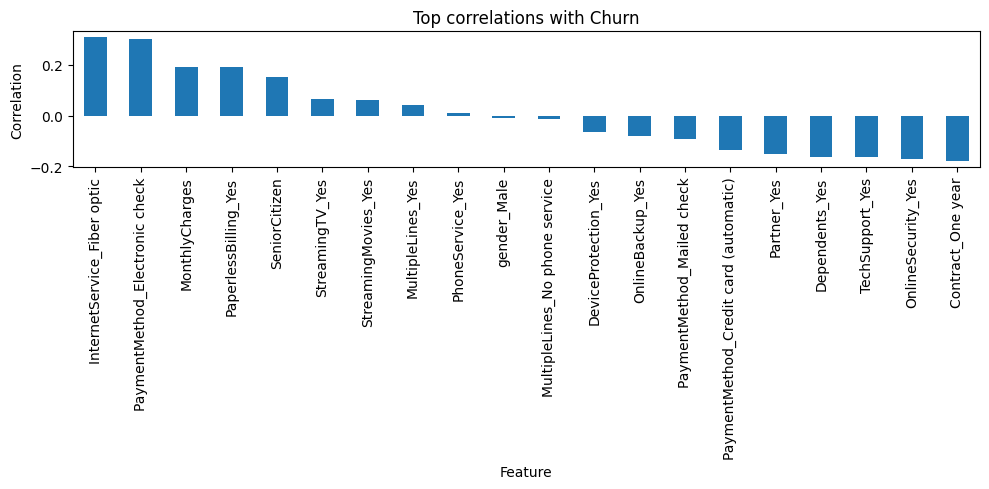

InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
MonthlyCharges                           0.192858
PaperlessBilling_Yes                     0.191454
SeniorCitizen                            0.150541
StreamingTV_Yes                          0.063254
StreamingMovies_Yes                      0.060860
MultipleLines_Yes                        0.040033
PhoneService_Yes                         0.011691
gender_Male                             -0.008545
MultipleLines_No phone service          -0.011691
DeviceProtection_Yes                    -0.066193
OnlineBackup_Yes                        -0.082307
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner_Yes                             -0.149982
Dependents_Yes                          -0.163128
TechSupport_Yes                         -0.164716
OnlineSecurity_Yes                      -0.171270
Contract_One year                       -0.178225


In [46]:
# Calculate correlation between each numeric column and the target 'Churn'
corr_with_churn = telecom_cust_dummies.corr(numeric_only=True)["Churn"].drop(labels=["Churn"]).sort_values(ascending=False)

# Choose how many top features to display (max 20 or fewer if limited)
top_k = 20 if corr_with_churn.size > 20 else corr_with_churn.size
corr_subset = corr_with_churn.head(top_k)

# Plot the correlations as a bar chart for easy comparison
plt.figure(figsize=(10, 5))
corr_subset.plot(kind="bar")
plt.title("Top correlations with Churn")
plt.xlabel("Feature")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

# Show the actual correlation values
corr_subset


## Visualize Tenure Distribution

* This plot shows how customer tenure is distributed across the dataset.
* A histogram is used to count how many customers fall into each tenure range, measured in months.
* This helps reveal patterns such as whether most customers are new, long-term, or somewhere in between.


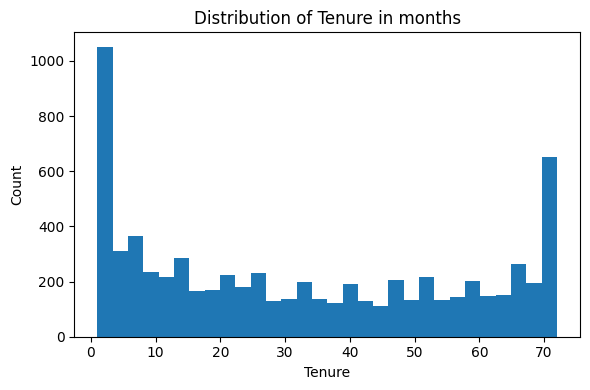

In [47]:
# Create a histogram to show how long customers have stayed in months
plt.figure(figsize=(6,4))
data_fr["tenure"].plot(kind="hist", bins=30)
plt.title("Distribution of Tenure in months")
plt.xlabel("Tenure")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Visualize Relationship Between Monthly and Total Charges

* This scatter plot shows how monthly charges relate to total charges across customers.
* Each point represents one customer, with monthly charges on the x-axis and total charges on the y-axis.
* This visualization helps reveal patterns such as whether higher monthly fees tend to result in higher total spending, and whether any unusual billing behaviors are present.


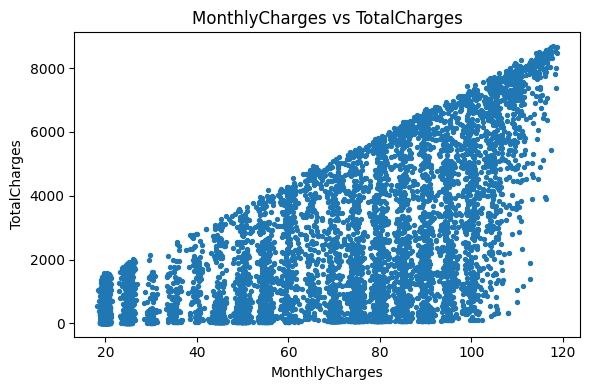

In [48]:
# Create a scatter plot to explore the relationship between monthly and total charges
plt.figure(figsize=(6,4))
plt.scatter(data_fr["MonthlyCharges"], data_fr["TotalCharges"], s=8)
plt.title("MonthlyCharges vs TotalCharges")
plt.xlabel("MonthlyCharges")
plt.ylabel("TotalCharges")
plt.tight_layout()
plt.show()


## Compare Tenure Distributions by Churn Status

* This box plot compares how long customers have stayed (tenure in months) based on whether they churned or not.
* The visualization highlights differences in tenure between the two groups, showing medians, quartiles, and potential outliers.
* This can help reveal whether shorter or longer customer lifespans are associated with higher churn risk.


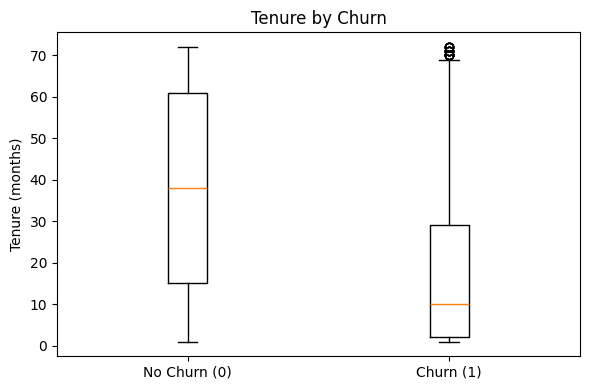

In [49]:
# eparate tenure values for customers who stayed vs those who churned
no_churn  = data_fr.loc[data_fr["Churn"]==0, "tenure"].values
yes_churn = data_fr.loc[data_fr["Churn"]==1, "tenure"].values

# Create a box plot to compare tenure distributions between the two groups
plt.figure(figsize=(6,4))
plt.boxplot([no_churn, yes_churn], labels=["No Churn (0)", "Churn (1)"])
plt.title("Tenure by Churn")
plt.ylabel("Tenure (months)")
plt.tight_layout()
plt.show()


## Split and Scale the Dataset for Modeling

* The full feature set and target variable are separated from the cleaned dataset.
* A stratified train-test split is applied to preserve the class balance of churn across both subsets.
* Feature values are then scaled using Min-Max normalization to ensure all inputs fall within the same range, which helps certain models perform more reliably.
* The final shapes of the training and test sets are printed to confirm the split.


In [50]:
# Extract the full feature matrix and target vector from the cleaned dataset
X_full = telecom_cust_dummies[feature_cols].copy()
y_full = telecom_cust_dummies["Churn"].copy()

# Split the data into training and test sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.25, random_state=SEED, stratify=y_full
)

# Scale feature values to a 0–1 range using Min-Max normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Print the shape of the training and test sets to confirm the split
X_train.shape, X_test.shape


((5274, 30), (1758, 30))

## Train and Evaluate Logistic Regression Model

* A logistic regression model is trained using the scaled training data.
* The model is configured to run for up to 1000 iterations to ensure convergence.
* After training, predictions are made on the test set, and accuracy is calculated to assess how well the model performs on unseen data.


In [51]:
# Initialize a logistic regression model with extended iteration limit and train the model using the training data
logist_reg = LogisticRegression(max_iter=1000)
logist_reg.fit(X_train_scaled, y_train)

# Predict churn outcomes on the scaled test data
y_pred_lr = logist_reg.predict(X_test_scaled)

# Calculate and print the accuracy of the model 
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression — Accuracy: {acc_lr:.4f}")


Logistic Regression — Accuracy: 0.8060


## Train and Evaluate a Random Forest Model with OOB Validation

* A Random Forest classifier is trained using the training data. The model is configured with 2000 trees, limited leaf nodes, and out-of-bag (OOB) scoring enabled.
* OOB scoring provides an internal estimate of generalization performance without needing a separate validation set.
* After training, predictions are made on the test set, and both test accuracy and OOB score are reported.


In [52]:
# Initialize a Random Forest model with specific settings
random_fr = RandomForestClassifier(
    n_estimators=2000,
    oob_score=True,
    max_features="sqrt",
    max_leaf_nodes=50,
    bootstrap=True,
    random_state=SEED,
    n_jobs=-1
)

# Train the model using the training data and predict churn outcomes on the test set
random_fr.fit(X_train, y_train)
y_pred_random_fr = random_fr.predict(X_test)

# Calculate accuracy on the test set
acc_random_fr = accuracy_score(y_test, y_pred_random_fr)

# Retrieve the out-of-bag score and compute its error
oob_score = random_fr.oob_score_
oob_error = 1.0 - oob_score

# Print the performance
print(f"Random Forest — Accuracy: {acc_random_fr:.4f}")
print(f"OOB score: {oob_score:.4f} | OOB error: {oob_error:.4f}")
print("OOB approximates generalisation without a separate validation set.")


Random Forest — Accuracy: 0.7918
OOB score: 0.7992 | OOB error: 0.2008
OOB approximates generalisation without a separate validation set.


## Confusion matrices (Logistic Regression vs Random Forest)
* I’m putting both models’ predictions next to the true labels in a compact table (the confusion matrix).
* This makes it easy to spot where each model gets confused:
* True Negatives (top-left): correctly predicts “no churn”.
* False Positives (top-right): predicts churn but the customer stayed.
* False Negatives (bottom-left): predicts no churn but the customer left (costly!).
* True Positives (bottom-right): correctly predicts churn.
* I’ll compare the two matrices to see which model makes fewer costly mistakes (especially false negatives).


LR Confusion (rows=true, cols=pred):
 [[1150  141]
 [ 200  267]]

random_fr Confusion (rows=true, cols=pred):
 [[1174  117]
 [ 249  218]]


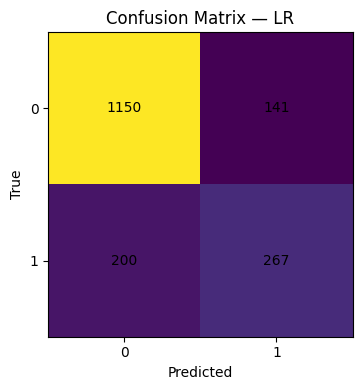

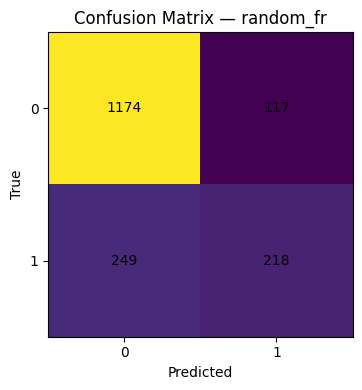

In [53]:
# Generate confusion matrices for both models using binary labels
con_mat_lr = confusion_matrix(y_test, y_pred_lr, labels=[0,1])
con_mat_random_fr = confusion_matrix(y_test, y_pred_random_fr, labels=[0,1])

# Print the raw confusion matrix values 
print("LR Confusion (rows=true, cols=pred):\n", con_mat_lr)
print("\nrandom_fr Confusion (rows=true, cols=pred):\n", con_mat_random_fr)

# Visualize Logistic Regression confusion
plt.figure(figsize=(4,4))
plt.imshow(con_mat_lr, interpolation='nearest')
plt.title("Confusion Matrix — LR")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["0","1"]); plt.yticks([0,1], ["0","1"])

# Lable each cell with its count
for (i,j), v in np.ndenumerate(con_mat_lr):
    plt.text(j, i, int(v), ha="center", va="center")
plt.tight_layout(); plt.show()

# Visualize Random Forest confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.imshow(con_mat_random_fr, interpolation='nearest')
plt.title("Confusion Matrix — random_fr")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["0","1"]); plt.yticks([0,1], ["0","1"])

# Lable each cell with its count
for (i,j), v in np.ndenumerate(con_mat_random_fr):
    plt.text(j, i, int(v), ha="center", va="center")
    
plt.tight_layout(); plt.show()


## Precision vs Recall (side-by-side)
* Here I look at precision and recall for each model:
* Precision: of all customers the model said will churn, how many actually did?
* Recall: of all customers who actually churned, how many did the model catch?
* If the business hates missed churners more than false alarms, recall matters more.
* I’ll note which model strikes the better balance for this use case and why.

In [54]:
# Calculate precision and recall for Logistic Regression
prec_lr = precision_score(y_test, y_pred_lr, zero_division=0)
rec_lr  = recall_score(y_test, y_pred_lr,  zero_division=0)

#alculate precision and recall for Random Forest
prec_random_fr = precision_score(y_test, y_pred_random_fr, zero_division=0)
rec_random_fr  = recall_score(y_test, y_pred_random_fr,  zero_division=0)

# Print both models' precision and recall scores for comparison
print(f"LR — Precision: {prec_lr:.4f} | Recall: {rec_lr:.4f}")
print(f"random_fr — Precision: {prec_random_fr:.4f} | Recall: {rec_random_fr:.4f}")


LR — Precision: 0.6544 | Recall: 0.5717
random_fr — Precision: 0.6507 | Recall: 0.4668


## Optimize Classification Thresholds Based on Cost and F1 Score

* Predicted probabilities for churn are extracted from both models.
* A custom cost function is defined to reflect business priorities: contacting a non-churner incurs a small cost, while missing a true churner is more expensive.
* Each threshold from 0 to 1 is evaluated to compute precision, recall, accuracy, and total cost.
* The best threshold is selected using two criteria: lowest cost and highest F1 score (with cost as a tie-breaker).
* This approach helps balance business impact with predictive performance.


In [55]:
# Predicted probabilities for the positive class (churn=1)
y_probability_lr = logist_reg.predict_proba(X_test_scaled)[:, 1]
y_probability_random_fr = random_fr.predict_proba(X_test)[:, 1]

# Define costs for prediction errors
C_FP = 1.0
C_FN = 5.0

# Evaluate model performance at a given threshold
def eval_threshold(y_true, y_proba, thr):
    y_hat = (y_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec  = recall_score(y_true, y_hat,  zero_division=0)
    acc  = accuracy_score(y_true, y_hat)
    cost = C_FP * fp + C_FN * fn
    return {"thr": thr, "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "acc": acc, "prec": prec, "rec": rec, "cost": cost}
    
#Evaluate performance across a range of thresholds
def sIep_thresholds(y_true, y_proba, steps=101):
    thrs = np.linspace(0.0, 1.0, steps)
    return [eval_threshold(y_true, y_proba, t) for t in thrs]

# Generate evaluation grids for both models
grid_lr = sIep_thresholds(y_test, y_probability_lr)
grid_random_fr = sIep_thresholds(y_test, y_probability_random_fr)

# Find best by (1) minimum cost, and (2) max F1 (tie-breaker on cost)
def best_by_cost(grid):
    best = min(grid, key=lambda d: (d["cost"], -2*(d["prec"]*d["rec"])/(d["prec"]+d["rec"]+1e-12)))
    return best

# Find best threshold by minimizing cos
def best_by_f1(grid):
    def f1(d): 
        return 0.0 if (d["prec"]+d["rec"])==0 else 2*(d["prec"]*d["rec"])/(d["prec"]+d["rec"])
    best = max(grid, key=lambda d: (f1(d), -d["cost"]))
    b = best.copy(); b["f1"] = f1(best); return b

#Select optimal thresholds for both models
best_lr_cost = best_by_cost(grid_lr)
best_random_fr_cost = best_by_cost(grid_random_fr)
best_lr_f1   = best_by_f1(grid_lr)
best_random_fr_f1   = best_by_f1(grid_random_fr)

def print_model_summary(title, metrics):
    print(f"\n {title}")
    print("-" * 50)
    print(f"Threshold       : {metrics['thr']:.4f}")
    print(f"True Positives  : {metrics['tp']}")
    print(f"False Positives : {metrics['fp']}")
    print(f"True Negatives  : {metrics['tn']}")
    print(f"False Negatives : {metrics['fn']}")
    print(f"Accuracy        : {metrics['acc']:.4f}")
    print(f"Precision       : {metrics['prec']:.4f}")
    print(f"Recall          : {metrics['rec']:.4f}")
    print(f"Cost            : {metrics['cost']:.4f}")
    if "f1" in metrics:
        print(f"F1 Score        : {metrics['f1']:.4f}")
    print("-" * 50)

# Print summaries
print_model_summary("Best Logistic Regression by COST", best_lr_cost)
print_model_summary("Best Random Forest by COST", best_random_fr_cost)
print_model_summary("Best Logistic Regression by F1", best_lr_f1)
print_model_summary("Best Random Forest by F1", best_random_fr_f1)



 Best Logistic Regression by COST
--------------------------------------------------
Threshold       : 0.1800
True Positives  : 415
False Positives : 501
True Negatives  : 790
False Negatives : 52
Accuracy        : 0.6854
Precision       : 0.4531
Recall          : 0.8887
Cost            : 761.0000
--------------------------------------------------

 Best Random Forest by COST
--------------------------------------------------
Threshold       : 0.1900
True Positives  : 418
False Positives : 520
True Negatives  : 771
False Negatives : 49
Accuracy        : 0.6763
Precision       : 0.4456
Recall          : 0.8951
Cost            : 765.0000
--------------------------------------------------

 Best Logistic Regression by F1
--------------------------------------------------
Threshold       : 0.3900
True Positives  : 330
False Positives : 235
True Negatives  : 1056
False Negatives : 137
Accuracy        : 0.7884
Precision       : 0.5841
Recall          : 0.7066
Cost            : 920.0000
F1 S

## Threshold tuning for Random Forest
* Instead of sticking with the default 0.50 cutoff, I’ll choose a custom threshold on the predicted churn probability.
* The idea is to trade off precision and recall to minimize the business cost (e.g., losing a customer vs. offering retention incentives).
* Get the predicted probability for churn = 1.
* Sweep thresholds between 0 and 1.
* For each threshold, compute the cost (using the cost weights I set).
* Pick the threshold with the lowest total cost, then convert probabilities to 0/1 using that threshold.
* This tuned cutoff often beats the default when class balance or costs are uneven.


TUNED random_fr @ threshold=0.190: acc=0.6763, prec=0.4456, rec=0.8951
Confusion (rows=true, cols=pred):
 [[771 520]
 [ 49 418]]


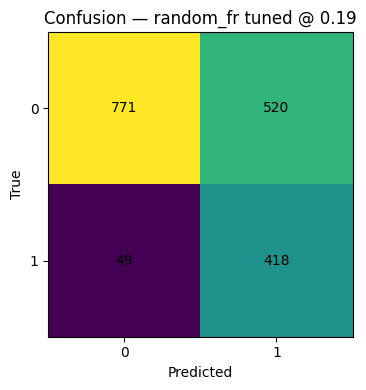

In [56]:
# Use the threshold that minimizes cost for Random Forest predictions and convert predicted probabilities into binary predictions 
thr = best_random_fr_cost["thr"]   
y_hat_tuned = (y_probability_random_fr >= thr).astype(int)

#
# Evaluate performance 
cm_tuned = confusion_matrix(y_test, y_hat_tuned, labels=[0,1])
prec_tuned = precision_score(y_test, y_hat_tuned, zero_division=0)
rec_tuned  = recall_score(y_test, y_hat_tuned, zero_division=0)
acc_tuned  = accuracy_score(y_test, y_hat_tuned)

#Print the tuned model's performance metrics
print(f"TUNED random_fr @ threshold={thr:.3f}: acc={acc_tuned:.4f}, prec={prec_tuned:.4f}, rec={rec_tuned:.4f}")
print("Confusion (rows=true, cols=pred):\n", cm_tuned)

# Visualize the tuned confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.imshow(cm_tuned, interpolation='nearest')
plt.title(f"Confusion — random_fr tuned @ {thr:.2f}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["0","1"]); plt.yticks([0,1], ["0","1"])

# Lable each cell with its count
for (i,j), v in np.ndenumerate(cm_tuned):
    plt.text(j, i, int(v), ha="center", va="center")
plt.tight_layout(); plt.show()


# Top features in the Random Forest

* I’m ranking inputs by how much they help the forest split the data (feature importance).
* This isn’t a causal story, but it’s a quick read on what the model leans on.
* The top contributors (e.g., contract type, tenure, monthly charges, etc.).
* A short note on whether these drivers make practical sense (e.g., higher monthly cost higher churn risk).
* Any surprises that might justify extra checks or new features.


In [57]:
# Extract feature importance scores from the trained Random Forest model print top 10 results
importances = pd.Series(random_fr.feature_importances_, index=feature_cols).sort_values(ascending=False)
top10 = importances.head(10)
top10


tenure                             0.201315
TotalCharges                       0.140801
InternetService_Fiber optic        0.098330
MonthlyCharges                     0.084571
Contract_Two year                  0.082143
PaymentMethod_Electronic check     0.074675
OnlineSecurity_Yes                 0.038659
Contract_One year                  0.034249
TechSupport_Yes                    0.029935
TechSupport_No internet service    0.018091
dtype: float64

## Display Model Performance Metrics at Default Threshold

* Accuracy, precision, and recall are calculated for both models using the default threshold of 0.5.
* These metrics are printed in a structured format to allow quick comparison between Logistic Regression and Random Forest.


In [58]:
# Create a plain numeric summary for both models at default threshold
summary_default = {
    "LR": {
        "acc": accuracy_score(y_test, y_pred_lr),
        "prec": precision_score(y_test, y_pred_lr, zero_division=0),
        "rec": recall_score(y_test, y_pred_lr, zero_division=0)
    },
    "random_fr": {
        "acc": accuracy_score(y_test, y_pred_random_fr),
        "prec": precision_score(y_test, y_pred_random_fr, zero_division=0),
        "rec": recall_score(y_test, y_pred_random_fr, zero_division=0)
    }
}

# Print the summary in a clean format
print("Model Performance at Default Threshold (0.5):")
print("-" * 50)
for model, metrics in summary_default.items():
    print(f"{model:<10} | Accuracy: {metrics['acc']:.4f} | Precision: {metrics['prec']:.4f} | Recall: {metrics['rec']:.4f}")



Model Performance at Default Threshold (0.5):
--------------------------------------------------
LR         | Accuracy: 0.8060 | Precision: 0.6544 | Recall: 0.5717
random_fr  | Accuracy: 0.7918 | Precision: 0.6507 | Recall: 0.4668


# Understanding the Confusion Matrix

The confusion matrix helps us see how well our model is predicting customer churn. It breaks down predictions into four categories:

## Precision vs. Recall

Let’s say your model flags 100 customers as likely to churn:

* Precision (churn) = Of those flagged, how many actually left?
* High precision - Few false alarms (low FP cost)
* Low precision - Many false alarms

* Recall (churn) = Of all actual churners, how many did we catch?
* High recall - Few missed churners (low FN cost)
* Low recall - Many missed churners

## Trade-Offs and Business Impact
* FN (missed churners) are more/less costly than FP (false alarms) depending on your business.
* If precision - recall, the model is conservative: fewer false alarms, but may miss churners.
* If recall - precision, the model is aggressive: catches more churners, but risks unnecessary outreach.


## Class Imbalance Warning

If churners are a small portion of your data:
* Accuracy can be misleading (e.g., predicting "stay" for everyone might still look accurate).Focus on precision, recall, and PR curves instead of raw accuracy.



# Logistic Regression vs Random Forest — which fits this task?
Here I compare the models on precision, recall, and the confusion matrices, not just accuracy.

# Interpretation guide (pick what matches your results):
* If Random Forest has higher recall (with acceptable precision): it’s better at catching churners (lower FN), which suits retention-first goals.
* If Logistic Regression has higher precision (with acceptable recall): it triggers fewer false alarms (lower FP), which suits cost-control goals where outreach is expensive.
* If both have similar dev/test accuracy but RF shows higher variance (big train–dev gap): LR might be more stable and easier to monitor.
* If calibration matters (probabilities used for budgeting/threshold tuning), LR is often easier to calibrate, though RF can be calibrated too.
# Decision for this task (fill in):
* Given our priority is minimise missed churners / minimise false alarms / balanced trade-off, and based on the numbers above, I select
# Random Forest / Logistic Regression because:
* It achieves higher recall / higher precision / best F1 on the development set, and
* It maintains similar / better performance on the test set without signs of severe overfitting.

